Saving children-born-per-woman.csv to children-born-per-woman (2).csv
Saving female-labor-force-participation-oecd.csv to female-labor-force-participation-oecd (2).csv
Saving marriage-rate-per-1000-inhabitants.csv to marriage-rate-per-1000-inhabitants (2).csv
Saving mean-years-of-schooling-female.csv to mean-years-of-schooling-female (2).csv
Saving period-average-age-of-mothers-birth-order.csv to period-average-age-of-mothers-birth-order (2).csv
=== Head of DataFrame ===


,Year,Labor_Force_Participation,Marriage_Rate,Fertility_Rate,Schooling_Years,Avg_Age_At_Birth,Marriage_Rate_MA,Fertility_Z,Schooling_Growth_%,Birth_Age_Group
0,1970,43.339195,10.6,2.515,11.00028,26.04,10.600000,3.359325,0.000000,26-29
1,1975,46.348672,10.0,1.815,11.40120,25.77,10.300000,-0.781498,3.644635,<26
2,1979,50.935010,10.4,1.843,11.69715,25.97,10.333333,-0.615865,6.335021,<26
3,1980,51.475681,10.6,1.861,12.27472,25.98,10.333333,-0.509387,11.585523,<26
4,1981,52.107301,10.6,1.847,12.43098,26.06,10.533333,-0.592203,13.006033,26-29



=== Descriptive Statistics ===


,Labor_Force_Participation,Marriage_Rate_MA,Fertility_Z,Schooling_Growth_%,Avg_Age_At_Birth
count,18.000000,18.000000,1.800000e+01,18.000000,18.000000
mean,55.639465,8.301852,-5.427757e-16,15.530054,27.673889
std,4.801785,1.602020,1.000000e+00,6.249845,1.234014
min,43.339195,6.800000,-8.465683e-01,0.000000,25.770000
25%,53.249520,6.875000,-6.099498e-01,13.789899,26.222500
50%,57.444690,7.516667,-4.531901e-01,18.150583,27.980000
75%,59.069825,10.233333,4.326503e-01,19.347189,28.607500
max,59.472472,10.600000,3.359325e+00,21.619722,29.290000


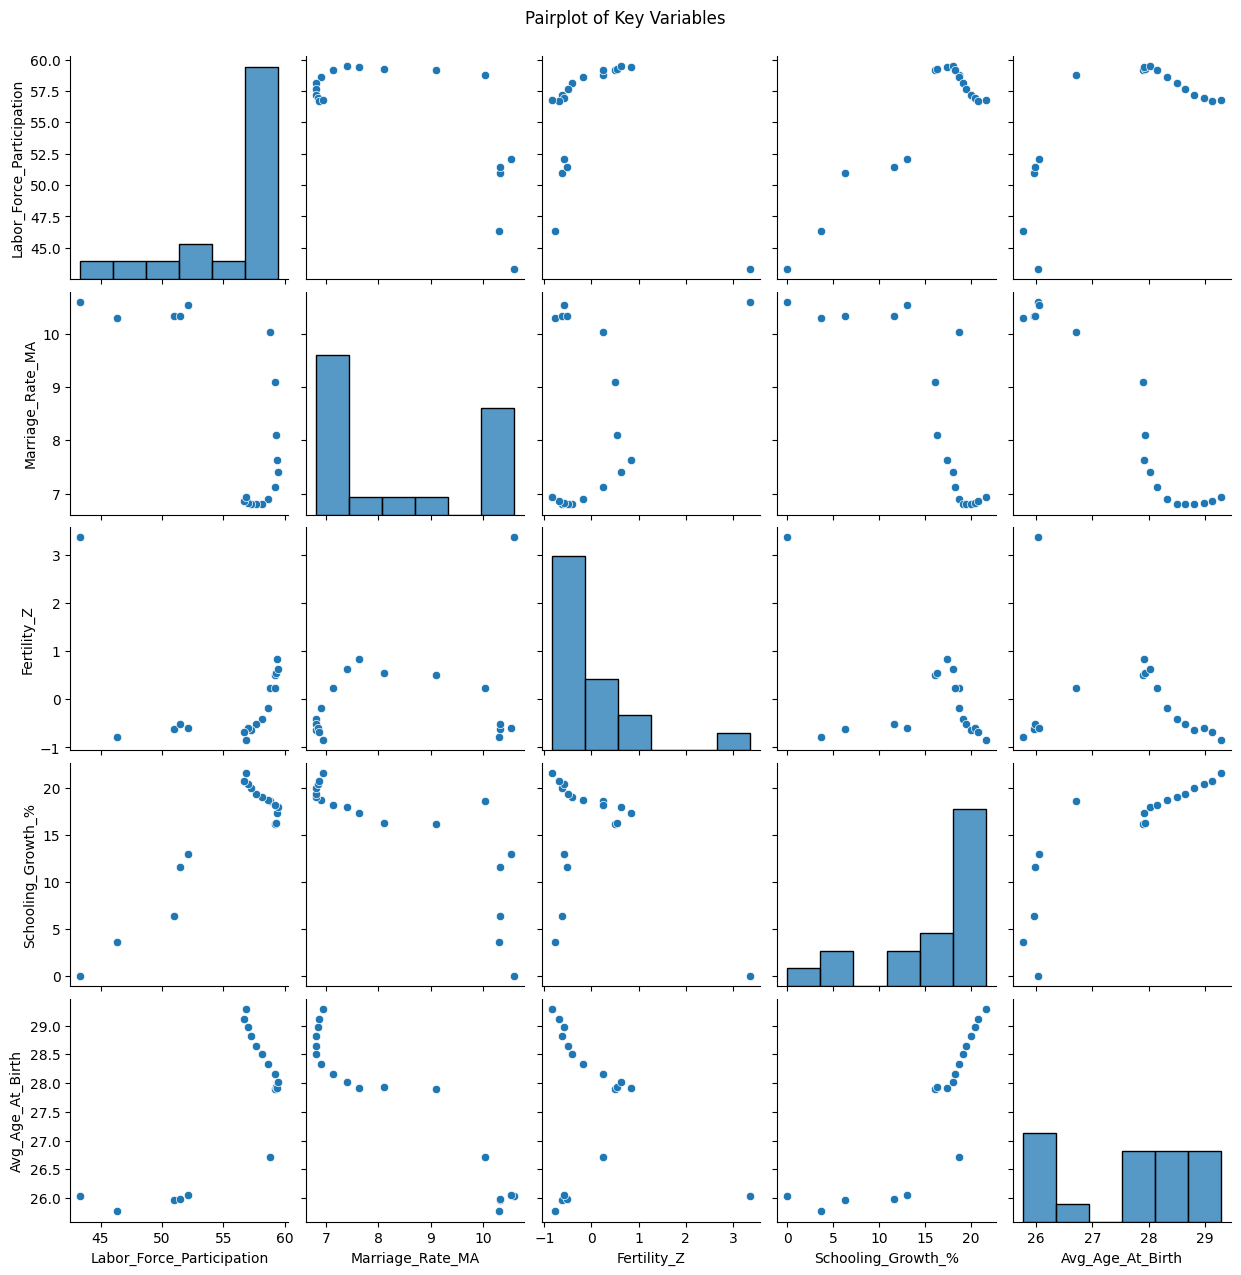

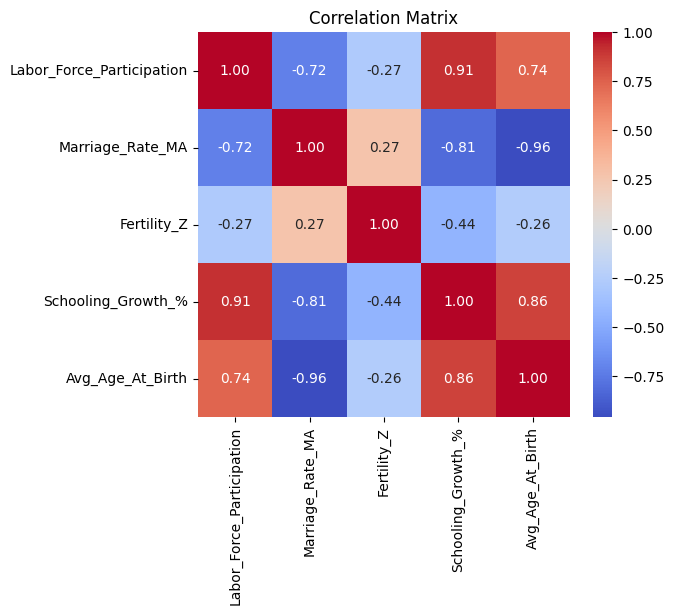


=== Pearson Correlations ===
Marriage_Rate_MA  : r = -0.716, p = 0.0008
Fertility_Z       : r = -0.272, p = 0.2757
Schooling_Growth_%: r = 0.909, p = 0.0000
Avg_Age_At_Birth  : r = 0.735, p = 0.0005

=== ANOVA by Birth_Age_Group ===
F = 3.81, p = 0.0461
→ Significant differences across age‐at‐birth groups.


<ipython-input-3-4ea60244d379>:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [grp['Labor_Force_Participation'].values for _, grp in df.groupby('Birth_Age_Group')]


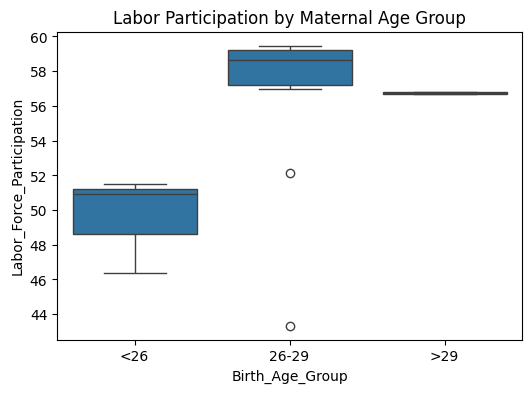

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, f_oneway
from google.colab import files


uploaded = files.upload()


labor      = pd.read_csv("female-labor-force-participation-oecd.csv")
marriage   = pd.read_csv("marriage-rate-per-1000-inhabitants.csv")
fertility  = pd.read_csv("children-born-per-woman.csv")
schooling  = pd.read_csv("mean-years-of-schooling-female.csv")
birth_age  = pd.read_csv("period-average-age-of-mothers-birth-order.csv")

labor = (labor[labor.Entity=="United States"]
         [['Year','Female labor force participation rate (OWID based on OECD 2017 and others)']]
         .rename(columns={'Female labor force participation rate (OWID based on OECD 2017 and others)': 'Labor_Force_Participation'}))

marriage = (marriage[marriage.Entity=="United States"]
            [['Year','Crude marriage rate (marriages per 1,000 people)']]
            .rename(columns={'Crude marriage rate (marriages per 1,000 people)': 'Marriage_Rate'}))

fertility = (fertility[fertility.Entity=="United States"]
             [['Year','Fertility rate (period), historical']]
             .rename(columns={'Fertility rate (period), historical': 'Fertility_Rate'}))

birth_age = (birth_age[birth_age.Entity=="United States"]
             [['Year','Period mean ages at birth - Total']]
             .rename(columns={'Period mean ages at birth - Total': 'Avg_Age_At_Birth'}))

# find & filter the schooling column
#    scan for any header containing 'schooling' to guard against slight name changes.
school_col = [c for c in schooling.columns if 'schooling' in c.lower()]
if not school_col:
    raise KeyError(f"No schooling column found in {schooling.columns.tolist()}")
school_col = school_col[0]
schooling = (schooling[schooling.Entity=="United States"]
             [['Year', school_col]]
             .rename(columns={school_col: 'Schooling_Years'}))


#    - Merge on 'Year' so all measures align on the same time points.
#    - Moving average smooths out short-term volatility in marriage rates, highlighting long-term trends.
#    - Z-score normalization of fertility puts it on a common scale and uncovers outliers.
#    - Percentage growth of schooling captures the increase relative to the base year, reflecting educational improvement over time.
#    - Binning maternal age makes it easy to compare groups (early vs. later childbirth) and run group-based tests.
df = (labor
      .merge(marriage, on='Year')
      .merge(fertility, on='Year')
      .merge(schooling, on='Year')
      .merge(birth_age, on='Year'))

df['Marriage_Rate_MA']    = df['Marriage_Rate'].rolling(window=3, min_periods=1).mean()
df['Fertility_Z']         = (df['Fertility_Rate'] - df['Fertility_Rate'].mean()) / df['Fertility_Rate'].std()
base_school               = df['Schooling_Years'].iloc[0]
df['Schooling_Growth_%']  = 100 * (df['Schooling_Years'] - base_school) / base_school
df['Birth_Age_Group']     = pd.cut(df['Avg_Age_At_Birth'],
                                   bins=[0,26,29,100],
                                   labels=['<26','26-29','>29'])
df.dropna(inplace=True)

# EDA: Summary & Visuals
print("=== Head of DataFrame ===")
display(df.head())
print("\n=== Descriptive Statistics ===")
display(df[['Labor_Force_Participation','Marriage_Rate_MA','Fertility_Z',
            'Schooling_Growth_%','Avg_Age_At_Birth']].describe())

# Pairplot to inspect relationships
sns.pairplot(df[['Labor_Force_Participation','Marriage_Rate_MA',
                 'Fertility_Z','Schooling_Growth_%','Avg_Age_At_Birth']])
plt.suptitle("Pairplot of Key Variables", y=1.02)
plt.show()

# Correlation heatmap
corr = df[['Labor_Force_Participation','Marriage_Rate_MA',
           'Fertility_Z','Schooling_Growth_%','Avg_Age_At_Birth']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Hypothesis Tests: Pearson correlations
print("\n=== Pearson Correlations ===")
for var in ['Marriage_Rate_MA','Fertility_Z','Schooling_Growth_%','Avg_Age_At_Birth']:
    r, p = pearsonr(df[var], df['Labor_Force_Participation'])
    print(f"{var:18s}: r = {r:.3f}, p = {p:.4f}")

# 9ANOVA: does labor participation differ by birth‐age group?
groups = [grp['Labor_Force_Participation'].values for _, grp in df.groupby('Birth_Age_Group')]
f_stat, p_val = f_oneway(*groups)
print(f"\n=== ANOVA by Birth_Age_Group ===\nF = {f_stat:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("→ Significant differences across age‐at‐birth groups.")
else:
    print("→ No significant differences across age‐at‐birth groups.")

# Boxplot for group comparison
plt.figure(figsize=(6,4))
sns.boxplot(x='Birth_Age_Group', y='Labor_Force_Participation', data=df, order=['<26','26-29','>29'])
plt.title("Labor Participation by Maternal Age Group")
plt.show()


['female-labor-force-participation-oecd.csv', 'marriage-rate-per-1000-inhabitants.csv', 'children-born-per-woman.csv', 'mean-years-of-schooling-female.csv', 'period-average-age-of-mothers-birth-order.csv']
